In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”


In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202, mOTUs sometimes has incompatible strings
correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [3]:
# setwd('~/m/msingle/mess/124_singlem-benchmarking/3_cami2_marine/')
# base_dir = './'
# base_dir = 'full_run8/checkout/1_novel_strains/' # Directory created when run in local scratch through queuing system

In [4]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [8]:
d1 = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
singlem,marine0
metaphlan,marine0
kraken,marine0


In [9]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
readit = function(tool, community){
    to_read = paste('output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [10]:
dim(d2)

[1] 9100    7

In [11]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.006740933
singlem,marine0,phylum,Bray-Curtis distance,0.023885652
singlem,marine0,class,Bray-Curtis distance,0.038664197


[1] 4550    5

In [12]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 350   5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.006740933
singlem,marine0,phylum,Bray-Curtis distance,0.023885652
singlem,marine0,class,Bray-Curtis distance,0.038664197
singlem,marine0,order,Bray-Curtis distance,0.066746154
singlem,marine0,family,Bray-Curtis distance,0.076211814
singlem,marine0,genus,Bray-Curtis distance,0.097096856
singlem,marine0,species,Bray-Curtis distance,0.153267515
metaphlan,marine0,kingdom,Bray-Curtis distance,0.015746311
metaphlan,marine0,phylum,Bray-Curtis distance,0.044338514


In [13]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.006740933
singlem,marine0,phylum,Bray-Curtis distance,0.023885652
singlem,marine0,class,Bray-Curtis distance,0.038664197


In [14]:
average_bc = bc[tool %in% correct_taxonomy_tools][, mean(value), by=list(tool)][order(V1)]
average_bc

tool,V1
<fct>,<dbl>
singlem,0.0790101
metaphlan,0.1000461
kraken,0.1401799
sourmash,0.1517289
metabuli,0.1786504


In [15]:
bcc = bc[tool %in% correct_taxonomy_tools]
bcc[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


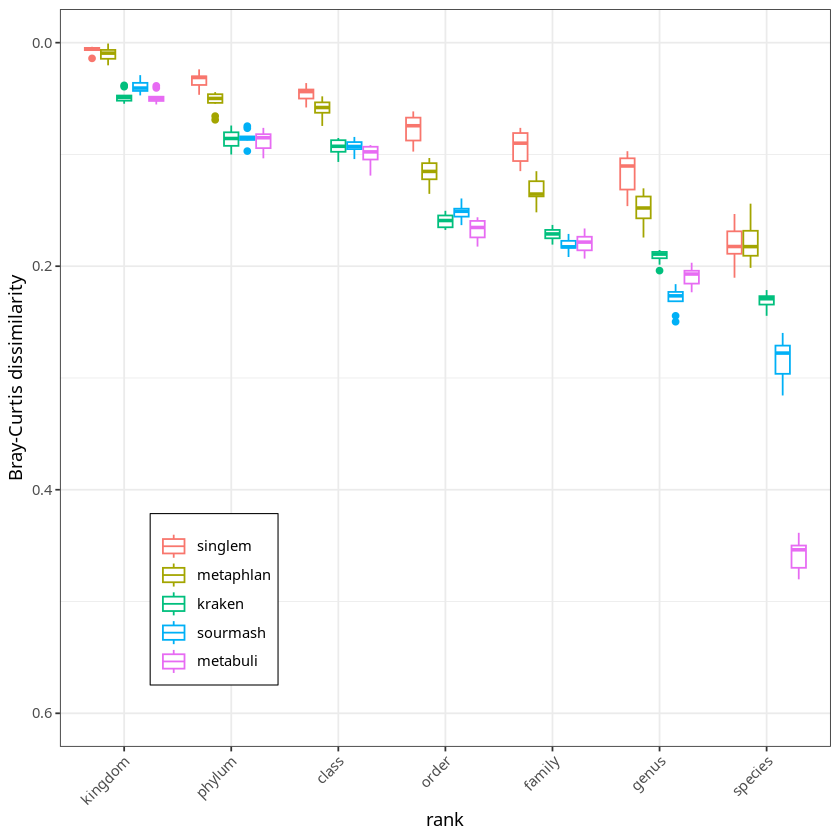

In [16]:
# Remove figure legend title, and put the legend in bottom left of plot, with a bounding box
qplot(data=bcc, rank, value, ylim=c(0.6,0), geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.title=element_blank()) + theme(legend.position=c(0.2,0.2)) + theme(legend.background = element_rect(colour = "black", size = 0.3))

In [18]:
# How much better is singlem than the next best tool?
means = bcc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='singlem', V1] - means[tool!='singlem', min(V1)]

tool,V1
<fct>,<dbl>
metabuli,0.4580929
sourmash,0.2837445
kraken,0.2314495
singlem,0.1801961
metaphlan,0.1789789


[1] 0.001217154

In [19]:
# write out bc
fwrite(bcc, 'bray-curtis.csv', sep='\t')

In [49]:
d3[metric=='Bray-Curtis distance'][rank=='genus'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
sourmash,0.2291805
metabuli,0.2090442
kraken,0.1910831
metaphlan,0.1497825
singlem,0.1167804


In [46]:
d3[metric=='F1 score'][rank=='species'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
metaphlan,0.9257511
singlem,0.7157610
sourmash,0.5392531
kraken,0.3369859
metabuli,0.1213895


In [47]:
d3[metric=='F1 score'][rank=='genus'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
metaphlan,0.9754939
singlem,0.8663457
kraken,0.6384775
sourmash,0.6133644
metabuli,0.2191415


In [50]:
d3[metric=='Purity'][rank=='species'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
sourmash,0.9626887
singlem,0.9622377
metaphlan,0.9444546
kraken,0.2037769
metabuli,0.0672677


In [52]:
d3[metric=='Completeness'][rank=='species'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
kraken,0.9939173
metaphlan,0.9078069
metabuli,0.6309737
singlem,0.5712804
sourmash,0.3758449


In [53]:
d3[metric=='Completeness'][rank=='genus'][,.(mean(value)), by=.(tool)][order(-V1)]

tool,V1
<fct>,<dbl>
kraken,0.9915413
metabuli,0.9573970
metaphlan,0.9522063
singlem,0.7688222
sourmash,0.4435420
